In [25]:
import pandas as pd 
import yfinance as yf 
import numpy as np 
import datetime as dt 
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('1_sorted_tsla.csv')
# df[abs(df['strike_price'] - 100) < 120]

In [3]:
filtered_df = df[abs(df['time_to_maturity'] - 30/365) < 3e-2]

# We need to keep option's date, exdate, cp_flag, strike_price, impl_volatility, time_to_maturity
filtered_df = filtered_df[['date', 'exdate', 'cp_flag', 'delta', 'impl_volatility', 'time_to_maturity']]
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
filtered_df['exdate'] = pd.to_datetime(filtered_df['exdate'])
filtered_df = filtered_df[abs(abs(filtered_df['delta']) - 0.5) <= 0.05]
filtered_df.sort_values(by='date', ascending=False)

# test_df = filtered_df.copy()
# test_df.drop_duplicates(subset=['date'], inplace=True)
# test_df = test_df.sort_values(by='date', ascending=False)
# test_df


,date,exdate,cp_flag,delta,impl_volatility,time_to_maturity
4540611,2023-08-31,2023-10-06,1,-0.531696,0.477869,0.098630
4539566,2023-08-31,2023-10-06,1,-0.480169,0.479928,0.098630
4539565,2023-08-31,2023-10-06,0,0.524161,0.484730,0.098630
4539564,2023-08-31,2023-09-29,1,-0.489367,0.446091,0.079452
4539563,2023-08-31,2023-09-29,0,0.514596,0.448506,0.079452
...,...,...,...,...,...,...
47889,2018-08-06,2018-09-14,1,-0.453126,0.433208,0.106849
47888,2018-08-06,2018-09-14,0,0.545787,0.432006,0.106849
47887,2018-08-06,2018-09-07,1,-0.453883,0.427940,0.087671
47886,2018-08-06,2018-09-07,0,0.545691,0.426261,0.087671


In [4]:
# Filter so that each date only has one option, chosen by abs(delta) being closest to 0.5
filtered_df = (
    filtered_df
    .assign(delta_abs=filtered_df["delta"].abs(),
            dist=(filtered_df["delta"].abs() - 0.5).abs())
    .sort_values(["date", "dist"])
    .drop_duplicates("date", keep="first")
    .drop(columns=["delta_abs", "dist"])
)
filtered_df

,date,exdate,cp_flag,delta,impl_volatility,time_to_maturity
49343,2018-08-06,2018-09-07,1,-0.500416,0.422765,0.087671
48631,2018-08-07,2018-08-31,0,0.502370,0.453020,0.065753
49072,2018-08-08,2018-08-31,0,0.499698,0.474713,0.063014
49844,2018-08-09,2018-09-14,1,-0.501533,0.530763,0.098630
49664,2018-08-10,2018-09-14,0,0.500920,0.506580,0.095890
...,...,...,...,...,...,...
4539522,2023-08-25,2023-09-15,1,-0.493554,0.437119,0.057534
4539454,2023-08-28,2023-09-22,1,-0.484767,0.449784,0.068493
4539766,2023-08-29,2023-09-29,1,-0.499308,0.445062,0.084932
4539845,2023-08-30,2023-09-29,0,0.501849,0.452296,0.082192


In [5]:
tsla_df = yf.download('TSLA', start='2018-08-06', end='2023-09-01') 
tsla_df.index = pd.to_datetime(tsla_df.index)
tsla_df = tsla_df.sort_index(ascending=False)
tsla_df


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2023-08-31,258.079987,261.179993,255.050003,255.979996,108861700
2023-08-30,256.899994,260.510010,250.589996,254.199997,121988400
2023-08-29,257.179993,257.480011,237.770004,238.580002,134047600
2023-08-28,238.820007,244.380005,235.350006,242.580002,107673700
2023-08-25,238.589996,239.000000,230.350006,231.309998,106612200
...,...,...,...,...,...
2018-08-10,23.699333,24.000000,23.066668,23.600000,173280000
2018-08-09,23.496668,24.467333,23.048668,24.370001,257757000


In [6]:
close_df = tsla_df['Close']
close_df.columns = ['Close']
close_df = close_df.reset_index().rename(columns={"Date": "date"})

merged_df = pd.merge(filtered_df, close_df, on='date', how='left')
merged_df


,date,exdate,cp_flag,delta,impl_volatility,time_to_maturity,Close
0,2018-08-06,2018-09-07,1,-0.500416,0.422765,0.087671,22.799334
1,2018-08-07,2018-08-31,0,0.502370,0.453020,0.065753,25.304667
2,2018-08-08,2018-08-31,0,0.499698,0.474713,0.063014,24.689333
3,2018-08-09,2018-09-14,1,-0.501533,0.530763,0.098630,23.496668
4,2018-08-10,2018-09-14,0,0.500920,0.506580,0.095890,23.699333
...,...,...,...,...,...,...,...
1272,2023-08-25,2023-09-15,1,-0.493554,0.437119,0.057534,238.589996
1273,2023-08-28,2023-09-22,1,-0.484767,0.449784,0.068493,238.820007
1274,2023-08-29,2023-09-29,1,-0.499308,0.445062,0.084932,257.179993
1275,2023-08-30,2023-09-29,0,0.501849,0.452296,0.082192,256.899994


In [39]:
# Get 30 days implied volatility 
merged_df['Log_return'] = np.log(close_df['Close'] / close_df['Close'].shift(1))

merged_df['ttm_days'] = (merged_df['exdate'] - merged_df['date']).dt.days

def get_RV(row, log_returns):
    window = int(row['ttm_days'])
    idx = log_returns.index.get_loc(row.name)
    if idx < window - 1:
        return np.nan
    window_returns = log_returns.iloc[idx - window + 1 : idx + 1]
    return window_returns.std() * np.sqrt(252)

merged_df['RV'] = merged_df.apply(get_RV, axis=1, log_returns=merged_df['Log_return'])
# rename column name implied_volatility to IV
merged_df = merged_df.rename(columns={"impl_volatility": "IV"})
merged_df["VRP"] = merged_df["IV"] - merged_df["RV"]
# Drop rows with NaN on VRP only 
# merged_df = merged_df.dropna(subset=['VRP'])
merged_df


,date,exdate,cp_flag,delta,IV,time_to_maturity,Close,Log_return,ttm_days,RV,VRP
167,2019-04-05,2019-04-26,1,-0.503333,0.527320,0.057534,18.330667,0.130590,21,NaN,NaN
169,2019-04-09,2019-05-03,0,0.505301,0.592159,0.065753,18.153999,-0.077726,24,NaN,NaN
171,2019-04-11,2019-05-10,1,-0.500985,0.588191,0.079452,17.894667,0.121138,29,NaN,NaN
172,2019-04-12,2019-05-10,0,0.491885,0.587915,0.076712,17.846666,0.017707,28,NaN,NaN
173,2019-04-15,2019-05-10,1,-0.500074,0.606787,0.068493,17.758667,0.093023,25,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1272,2023-08-25,2023-09-15,1,-0.493554,0.437119,0.057534,238.589996,-0.002585,21,0.556756,-0.119637
1273,2023-08-28,2023-09-22,1,-0.484767,0.449784,0.068493,238.820007,-0.008588,25,0.543129,-0.093345
1274,2023-08-29,2023-09-29,1,-0.499308,0.445062,0.084932,257.179993,0.049513,31,0.533038,-0.087976
1275,2023-08-30,2023-09-29,0,0.501849,0.452296,0.082192,256.899994,0.024618,30,0.543510,-0.091214


In [ ]:
merged_df = pd.read_csv('merged_data.csv')
# The first 36 rows have NaN on VRP (index < lookback_days (time_to_maturity))
# Remove these rows to remove null values 
merged_df = merged_df.iloc[36:]
# Reset index 
merged_df = merged_df.reset_index(drop=True) 
merged_df

,date,exdate,cp_flag,delta,IV,time_to_maturity,Close,Log_return,ttm_days,RV,VRP
0,2018-09-26,2018-10-19,0,0.502973,0.551835,0.063014,20.638666,-0.021496,23,0.473251,0.078584
1,2018-09-27,2018-10-19,0,0.504046,0.555472,0.060274,20.501333,-0.008121,22,0.485406,0.070066
2,2018-09-28,2018-10-26,0,0.500842,0.704135,0.076712,17.651333,-0.000667,28,0.447575,0.256560
3,2018-10-01,2018-11-09,0,0.501776,0.655187,0.106849,20.713333,0.017720,39,0.492057,0.163130
4,2018-10-02,2018-11-09,0,0.500625,0.647524,0.104110,20.068001,0.007659,38,0.498625,0.148899
...,...,...,...,...,...,...,...,...,...,...,...
1236,2023-08-25,2023-09-15,1,-0.493554,0.437119,0.057534,238.589996,-0.002585,21,0.556756,-0.119637
1237,2023-08-28,2023-09-22,1,-0.484767,0.449784,0.068493,238.820007,-0.008588,25,0.543129,-0.093345
1238,2023-08-29,2023-09-29,1,-0.499308,0.445062,0.084932,257.179993,0.049513,31,0.533038,-0.087976
1239,2023-08-30,2023-09-29,0,0.501849,0.452296,0.082192,256.899994,0.024618,30,0.543510,-0.091214


In [46]:
merged_df.to_csv('merged_data.csv', index=False)

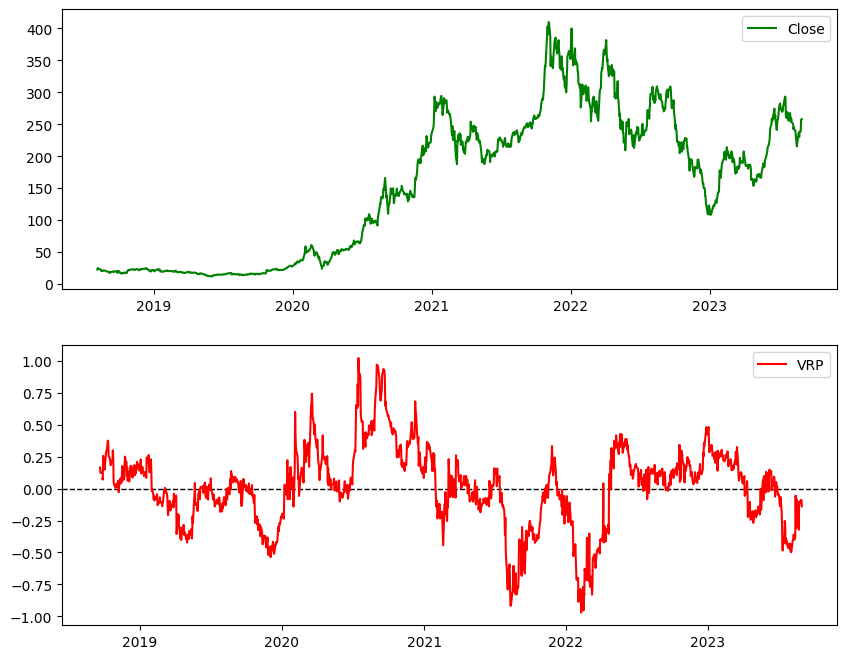

In [31]:
# Plot VRP and Close price on figure (2,1)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(merged_df['date'], merged_df['Close'], label='Close', color='green')
axs[0].legend()
# set a 0 line on axs[1]
axs[1].axhline(0, color='black', linewidth=1, linestyle='--')
axs[1].plot(merged_df['date'], merged_df['VRP'], label='VRP', color='red')
axs[1].legend()
